In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import multiset
import random
import scipy.stats

import tqdm.notebook
import collections
import sortedcontainers

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
orig_points = pd.read_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/points.txt", sep="\s+")
counts = pd.read_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/counts.txt", sep="\s+")
min_dist = counts.value.iloc[1]

Text(0, 0.5, 'Count')

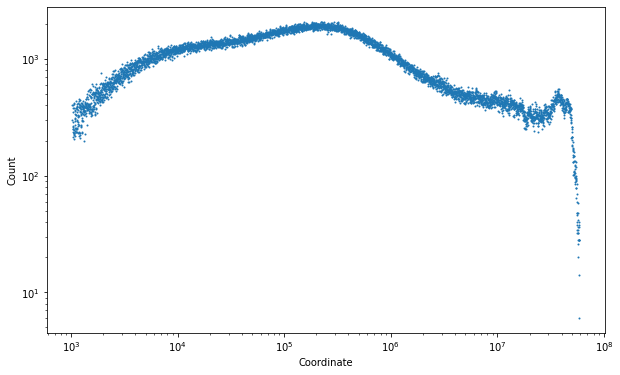

In [3]:
plt.figure(figsize=(10,6))
plt.plot(
    counts.value,
    counts.p,
    '.',
    ms=2
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coordinate")
plt.ylabel("Count")

In [ ]:
# class CoordinateMapper(object):
#     def __init__(self, points):
#         # List of all current coords        
#         self.coords = points.ravel()
#         self.max = self.coords.max()
                
#         # Inverse multimap
#         self.inverse_map = [[] for i in tqdm.notebook.trange(self.max+1)]
#         for i, coord in enumerate(tqdm.notebook.tqdm(self.coords)):
#             self.inverse_map[coord].append(i)
        
#         # Pointers to next larger
#         self.next_larger = np.zeros(self.max+1, dtype=int)
#         last = -1
#         for i in tqdm.notebook.trange(self.max, -1, -1):
#             if len(self.inverse_map[i]) == 0:
#                 self.next_larger[i] = last
#             else:
#                 self.next_larger[i] = i
#                 last = i
                
#         # Pointers to next smaller
#         self.next_smaller = np.zeros(self.max+1, dtype=int)
#         last = -1
#         for i in tqdm.notebook.trange(self.max+1):
#             if len(self.inverse_map[i]) == 0:
#                 self.next_smaller[i] = last
#             else:
#                 self.next_smaller[i] = i
#                 last = i
    
#     def sample_coordinate(self):
#         return random.choice(self.coords)
    
#     def remove(self, coordinate):
#         # Update inverse map and coords
#         assert len(self.inverse_map[coordinate]) > 0
#         pos = self.inverse_map[coordinate].pop()
        
#         if pos == len(self.coords)-1:
#             self.coords = self.coords[:-1]
#         else:
#             lst = self.inverse_map[self.coords[-1]]
#             lst.pop(lst.index(len(self.coords)-1))
#             lst.append(pos)
            
#             self.coords[pos] = self.coords[-1]
#             self.coords = self.coords[:-1]
            
#         # Update next larger and next smaller
#         if len(self.inverse_map[coordinate]) == 0:
#             # Next larger
#             if coordinate+1 <= self.max:
#                 next_ptr = self.next_larger[coordinate+1]
#             else:
#                 next_ptr = -1
            
#             pos = coordinate
#             while pos >= 0 and self.next_larger[pos] == coordinate:
#                 self.next_larger[pos] = next_ptr
#                 pos -= 1
                
#             # Next smaller
#             if coordinate-1 >= 0:
#                 next_ptr = self.next_smaller[coordinate-1]
#             else:
#                 next_ptr = -1
            
#             pos = coordinate
#             while pos <= self.max and self.next_smaller[pos] == coordinate:
#                 self.next_smaller[pos] = next_ptr
#                 pos += 1
            
    
#     def get_next_larger(self, position):
#         return self.next_larger[position]
    
#     def get_next_smaller(self, position):
#         return self.next_smaller[position]

In [4]:
class SortedCoordinateMapper(object):
    def __init__(self, points):
        self.max = np.array(points).max()        
        self.coords = sortedcontainers.SortedList(np.array(points).ravel())
        self.n_coords = len(self.coords)
    
    def sample_coordinate(self):
        return self.coords[np.random.choice(len(self.coords))]
    
    def remove(self, coordinate):
        self.coords.remove(coordinate)
    
    def get_next_larger(self, position):
        x = self.coords.bisect_left(position)
        if x == len(self.coords):
            return -1
        else:
            return self.coords[x]
    
    def get_next_smaller(self, position):
        x = self.coords.bisect_right(position)
        if x == 0:
            return -1
        else:
            return self.coords[x-1]
    
# small_points = (orig_points.values).astype(int)
# CM = SortedCoordinateMapper(small_points)

In [45]:
class DiagonalSampler(object):
    def __init__(self, points, min_dist, mapper_type=SortedCoordinateMapper):
        self.n_points = points.shape[0]
        self.diagonals = np.sort(np.abs(np.diff(points, axis=1)).astype(int).ravel())
        self.mapper = mapper_type(points.astype(int))
        self.max = self.mapper.max
        self.min_dist = min_dist
        
    def build(self, diagonal_in_order=False, greedy_small=False):
        new_points = []
        
        for n_point in tqdm.notebook.trange(self.n_points):            
            best_y = np.inf
            
            while True:
                x = self.mapper.sample_coordinate()
                
                if diagonal_in_order:
                    d = self.diagonals[n_point]
                elif greedy_small:
                    d = self.min_dist
                else:
                    d = random.choice(self.diagonals)



                candidates = []
                if x+d <= self.max:
                    candidates.extend([self.mapper.get_next_larger(x+d), self.mapper.get_next_smaller(x+d)])
                else:
                    candidates.append(self.mapper.get_next_smaller(self.max+1))
                if 0<= x-d:
                    candidates.extend([self.mapper.get_next_larger(x-d), self.mapper.get_next_smaller(x-d)])
                else:
                    candidates.append(self.mapper.get_next_larger(-1))

                random.shuffle(candidates)

                for y in candidates:
                    if y != -1 and \
                        y != x and \
                        np.abs(np.abs(y-x)-d) < np.abs(np.abs(best_y-x)-d):
                        best_y = y

                if best_y != np.inf:
                    break
                    
            assert best_y in self.mapper.coords
            new_points.append(list(sorted([x, best_y])))
            self.mapper.remove(x)
            self.mapper.remove(best_y)
            
        self.new_points = np.array(new_points)
    
    def fix(self):
        for n_point in tqdm.notebook.trange(self.n_points):
            while np.abs(self.new_points[n_point, 1] - self.new_points[n_point, 0]) < self.min_dist:
                j = np.random.choice(self.n_points)
                if np.abs(self.new_points[n_point, 0] - self.new_points[j, 1]) >= self.min_dist and \
                    np.abs(self.new_points[n_point, 1] - self.new_points[j, 0]) >= self.min_dist:
                    self.new_points[n_point, 1], self.new_points[j, 1] = self.new_points[j, 1], self.new_points[n_point, 1]


        
    
    
    


In [28]:
small_points = (orig_points.values[:, :]).astype(int)
DS = DiagonalSampler(small_points, 1024)

DS.build(diagonal_in_order=False, greedy_small=True)
DS.fix()

  0%|          | 0/5018224 [00:00<?, ?it/s]

  0%|          | 0/5018224 [00:00<?, ?it/s]

In [32]:
np.abs(np.diff(DS.new_points, axis=1)).min()

1024

In [33]:
collections.Counter(np.array(DS.new_points).ravel()) == collections.Counter(np.array(small_points).ravel())

True

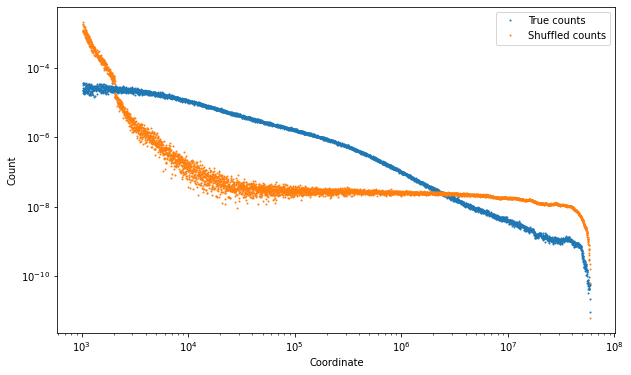

In [34]:
plt.figure(figsize=(10,6))
plt.plot(
    counts.value[:-1],
    np.histogram(np.abs(np.diff(small_points, axis=1).ravel()), bins=counts.value, density=True)[0],
    '.',
    ms=2,
    label="True counts"
)

plt.plot(
    counts.value[:-1],
    np.histogram(np.abs(np.diff(DS.new_points, axis=1).ravel()), bins=counts.value, density=True)[0],
    '.',
    ms=2,
    label="Shuffled counts"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coordinate")
plt.ylabel("Count")
plt.legend()

In [35]:
pd.DataFrame(DS.new_points, columns=["start1", "start2"])\
    .to_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/points_magic_shuffled_20210511_greedy_small.txt", sep="\t", index=False)

In [38]:
from math import ceil, log2

"""
van Emde Boas Tree is a data structure which gives O(log(log(u))
query time for operations like 
insert, search, delete, successor and predecessor
VEB class contains attribute
min, max, u, w, cluster and summary
initially min=max=NULL
u = size of universe (the range of total possible entries)
w = word length (number of bits in u)
w = log2(u)
cluster is an array of VEB structures of size of sqrt(u)
summary is a VEB of size sqrt(u)
when the size of VEB structure reaches we don't store clusters and summary vector
min and max are enough to store this structure.
"""


class VEB:
    """Index of x can be determined as the
    cluster number and the position inside the cluster
    for example lets consider 11
    in binary it is written as 1011
    so first half parts of the binary strinig give cluster number
    and 2nd half gives the postiton inside cluster
    cluster number= int(10)= 2
    position inside cluster= int(11)=3
    so 11 is in 2nd cluster at 3rd position
    where counting starts from 0th position
    0,1,2,3|4,5,6,7|8,9,10,11|12,13,14,15
                           ^
    here we use 'c' to denote cluster number
    and 'i' to denote index inside the cluster
    so x can be represented as <c,i>
    where x = c * sqrt(u) + i
    """

    def high(self, x):
        # high(x)=x//int(sqrt(u))
        return x >> (self.w // 2)

    def low(self, x):
        # low(x)= x%int(sqrt(u))
        return x & (1 << (self.w // 2)) - 1

    def index(self, i, j):
        # return i*int(sqrt(self.u))+j
        return i << (self.w // 2) | j

    def __init__(self, u):
        """
        This have been implemented using hash table
        to reduce the space complexity from O(U) to O(n*log(log(u))
        because u can be very large. for example if word size = 64 bits
        u= 2^64 = 16 million TB which can't be stored practically on ram.
        where as n*log*log*u can be O(3n) which can be easily stored.
        I have a different code for array implementation too.
        """

        self.w = ceil(log2(u))
        # self.u = 2 ** self.w
        self.min = self.max = None

        if self.w >= 1:  # when u==2^w=2 min and max are enough so we stop recursion
            self.cluster = {}
            self.summary = None

    def member(self, x):
        """Function to check if x is present in tree or not."""
        if x == self.min or x == self.max:
            return True
        elif self.w == 1:
            return False
        else:
            c = self.high(x)
            i = self.low(x)
            if c in self.cluster:
                return self.cluster[c].member(i)
            else:
                return False

    def insert(self, x):
        if self.min is None:
            self.min = x
            self.max = x
            return
        else:
            if x < self.min:
                x, self.min = self.min, x
            c = self.high(x)
            i = self.low(x)
            if self.w > 1:
                if c not in self.cluster:
                    self.cluster[c] = VEB(2 ** (self.w // 2))
                if self.cluster[c].min is None:
                    if self.summary is None:
                        self.summary = VEB(2 ** (self.w // 2))
                    self.summary.insert(c)
                if c not in self.cluster:
                    self.cluster[c] = VEB(2 ** (self.w // 2))
                self.cluster[c].insert(i)
            if x > self.max:
                self.max = x

    def successor(self, x):
        if self.w == 1:
            if x == 0 and self.max == 1:
                return 1
            else:
                return None
        elif self.min is not None and x < self.min:
            return self.min
        else:
            c = self.high(x)
            i = self.low(x)
            if c in self.cluster:
                maxlow = self.cluster[c].max
            else:
                maxlow = None
            if maxlow is not None and i < maxlow:
                offset = self.cluster[c].successor(i)
                return self.index(c, offset)
            else:
                if self.summary is not None:
                    succ_cluster = self.summary.successor(self.high(x))
                else:
                    succ_cluster = None
                if succ_cluster is None:
                    return None
                else:
                    offset = self.cluster[succ_cluster].min
                    return self.index(succ_cluster, offset)

    def predecessor(self, x):
        if self.w == 1:
            if x == 1 and self.min == 0:
                return 0
            else:
                return None
        elif self.max is not None and x > self.max:
            return self.max
        else:
            c = self.high(x)
            i = self.low(x)
            if c in self.cluster:
                min_low = self.cluster[c].min
            else:
                min_low = None
            if min_low is not None and i > min_low:
                offset = self.cluster[c].predecessor(i)
                return self.index(c, offset)
            else:
                if self.summary is not None:
                    prev_cluster = self.summary.predecessor(c)
                else:
                    prev_cluster = None
                if prev_cluster is None:
                    if self.min is not None and x > self.min:
                        return self.min
                    else:
                        return None
                else:
                    offset = self.cluster[prev_cluster].max
                    return self.index(prev_cluster, offset)

    def delete(self, x):
        if self.min is None:
            return
        if x < self.min or x > self.max:
            return
        if self.min == self.max:
            self.min = self.max = None
        elif self.w == 1:
            if x == 0:
                self.min = 1
            else:
                self.min = 0
            self.max = self.min
        else:
            c = self.high(x)
            i = self.low(x)
            if x == self.min:
                if self.summary:
                    first_cluster = self.summary.min
                else:
                    first_cluster = None
                if first_cluster:
                    x = self.index(first_cluster, self.cluster[first_cluster].min)
                    self.min = x
            if c in self.cluster:
                self.cluster[c].delete(i)
                if self.cluster[c].min is None:
                    self.summary.delete(c)
                if x == self.max:
                    summary_max = self.summary.max
                    if summary_max is None:
                        self.max = self.min
                    else:
                        self.max = self.index(summary_max, self.cluster[summary_max].max)
            elif x == self.max:
                self.max = self.index(c, self.cluster[c].max)
                
              

In [48]:
class VEBCoordinateMapper(object):
    def __init__(self, points):
        self.max = np.array(points).max()      
        
        self.coords = sortedcontainers.SortedList(np.array(points).ravel())
        self.veb = VEB(self.max+1)
        for coord in tqdm.notebook.tqdm(self.coords):
            self.veb.insert(coord)
        
        self.n_coords = len(self.coords)
    
    def sample_coordinate(self):
        return self.coords[np.random.choice(len(self.coords))]
    
    def remove(self, coordinate):
        self.coords.remove(coordinate)
        self.veb.delete(coordinate)
    
    def get_next_larger(self, position):
        #x = self.coords.bisect_left(position)
        x = self.veb.successor(position)
        if x == None:
            return -1
        else:
            return x
    
    def get_next_smaller(self, position):
        x = self.veb.predecessor(position)
        if x == None:
            return -1
        else:
            return x
    
# small_points = (orig_points.values).astype(int)
# CM = SortedCoordinateMapper(small_points)

In [49]:
small_points = (orig_points.values).astype(int)

DS = DiagonalSampler(small_points, 1024, mapper_type=VEBCoordinateMapper)

DS.build(diagonal_in_order=False, greedy_small=False)
DS.fix()

  0%|          | 0/10036448 [00:00<?, ?it/s]

  0%|          | 0/5018224 [00:00<?, ?it/s]

TypeError: unsupported operand type(s) for |: 'int' and 'NoneType'

In [50]:
%debug

> <ipython-input-38-dbf2bf9c9b12>(49)index()
     47     def index(self, i, j):
     48         # return i*int(sqrt(self.u))+j
---> 49         return i << (self.w // 2) | j
     50 
     51     def __init__(self, u):

ipdb> p i,j
(15, None)
ipdb> u
> <ipython-input-38-dbf2bf9c9b12>(123)successor()
    121             if maxlow is not None and i < maxlow:
    122                 offset = self.cluster[c].successor(i)
--> 123                 return self.index(c, offset)
    124             else:
    125                 if self.summary is not None:

ipdb> p c, offset
(15, None)
ipdb> u
> <ipython-input-38-dbf2bf9c9b12>(126)successor()
    124             else:
    125                 if self.summary is not None:
--> 126                     succ_cluster = self.summary.successor(self.high(x))
    127                 else:
    128                     succ_cluster = None

ipdb> p x
7829
ipdb> p self.high(x)
122
ipdb> u
> <ipython-input-38-dbf2bf9c9b12>(122)successor()
    120                 m